In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

df_master = pd.read_csv('GOLD_H4.csv')
df = df_master.drop(['volume'], axis=1).copy()
df['time'] = pd.to_datetime(df.time)

#Feature Create
import ta
df['rsi14'] = ta.momentum.rsi(df.close, n=14)
df['rsi14-t1'] = df['rsi14'].shift(1)
df['bbh'] = ta.volatility.bollinger_hband(df['close']) - df['close']
df['bbh-t1'] = df['bbh'].shift(1) 
df['open-close'] = df.open - df.close
df['open-close-t1'] = df['open-close'].shift(1)
df['high-low'] = df.high - df.low
df['high/open'] = df.high/df.open

df['efg_up'] = (df.close >= df.close.shift(1)) & (df.open <= df.open.shift(1))
df['efg_down'] = (df.close <= df.close.shift(1)) & (df.open >= df.open.shift(1))

df['new_high'] = df.high/df.high.rolling(6).max()

df['stoc'] = ta.momentum.stoch(df.high, df.low, df.close)

df['ma5'] = df.close.rolling(3).mean().diff()

df['adx'] = ta.trend.adx(df.high, df.low, df.close)

df['high-low-t1'] = df['high-low'].shift(1)



df['label'] = (df.close.rolling(5, center=True).mean().diff() > 0).astype(int)

df.dropna(inplace=True)

In [45]:
df.isna().sum().sum()

0

In [46]:
import DeeperTradeLibrary as dpt

df_train = df.iloc[:14000, :].copy()
df_valid = df.iloc[14000:18000, :].copy()
df_test = df.iloc[18000:, :].copy()

X_train = df_train.loc[:, 'rsi14':'high-low-t1'].copy()
y_train = df_train['label']

X_valid = df_valid.loc[:, 'rsi14':'high-low-t1'].copy()
y_valid = df_valid['label']

X_test = df_test.loc[:, 'rsi14':'high-low-t1'].copy()
y_test = df_test['label']

In [47]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=50000)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid),early_stopping_rounds=10)

y_pred = model.predict(X_test)

[1]	valid_0's binary_logloss: 0.659063
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.628341
[3]	valid_0's binary_logloss: 0.603118
[4]	valid_0's binary_logloss: 0.581415
[5]	valid_0's binary_logloss: 0.563354
[6]	valid_0's binary_logloss: 0.54815
[7]	valid_0's binary_logloss: 0.535044
[8]	valid_0's binary_logloss: 0.524085
[9]	valid_0's binary_logloss: 0.514593
[10]	valid_0's binary_logloss: 0.506683
[11]	valid_0's binary_logloss: 0.499505
[12]	valid_0's binary_logloss: 0.493332
[13]	valid_0's binary_logloss: 0.487967
[14]	valid_0's binary_logloss: 0.483572
[15]	valid_0's binary_logloss: 0.479878
[16]	valid_0's binary_logloss: 0.476705
[17]	valid_0's binary_logloss: 0.473606
[18]	valid_0's binary_logloss: 0.471197
[19]	valid_0's binary_logloss: 0.469061
[20]	valid_0's binary_logloss: 0.467289
[21]	valid_0's binary_logloss: 0.465641
[22]	valid_0's binary_logloss: 0.464191
[23]	valid_0's binary_logloss: 0.462976
[24]	valid_0's binary_loglos

In [29]:
pred = model.predict(X_test)
accuracy_score(pred, y_test)

0.7807989960259359

In [20]:
accuracy_score(y_train, model.predict(X_train))

0.7835

In [6]:
accuracy_score(y_test, model.predict(X_test))

0.7213971972390714

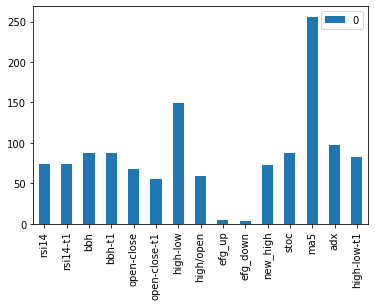

In [48]:
pd.DataFrame(model.feature_importances_, X_test.columns).plot.bar()

In [50]:
df_test['signal'] = model.predict(X_test)

In [53]:
result = dpt.Backtest.trade_simulation(df_test.copy(), commission=80, digit=1, pip_profit=30)

In [33]:
result.pnl.mean()/result.pnl.std()

0.05774135805391301

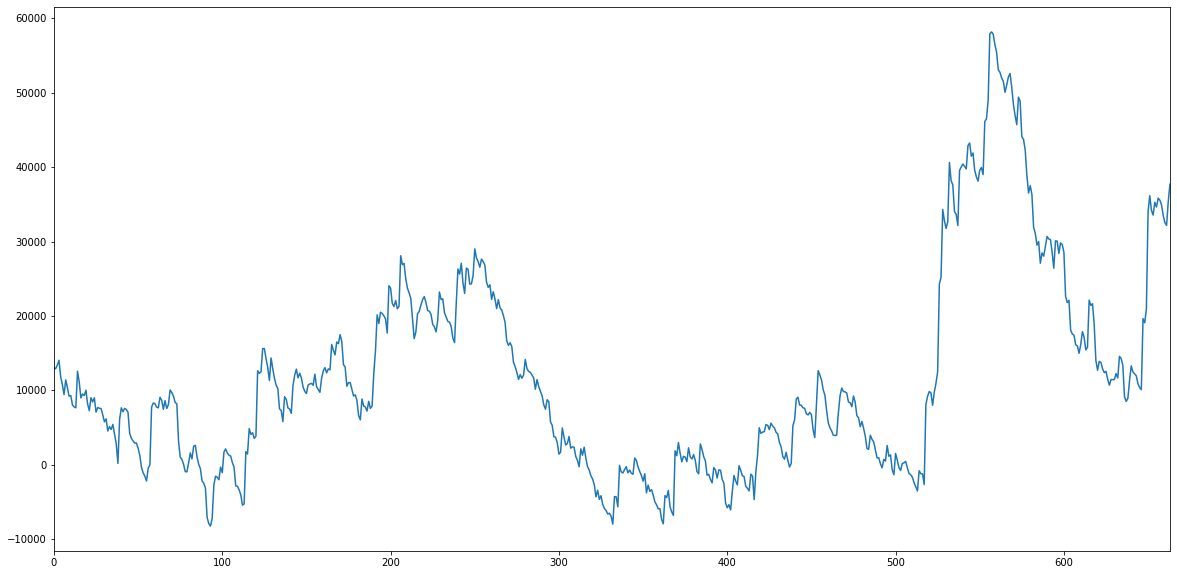

In [54]:
(result.equity + 10000).plot(figsize=(20,10))

In [14]:
result.set_index('open_time', drop=False, inplace=True)

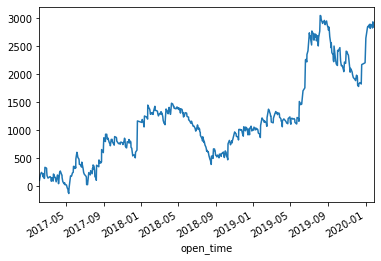

In [15]:
result.equity.plot()